In [1]:
import glob

from astropy import units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
#import ccdproc
from astropy.table import Table
from astropy.modeling import models
from matplotlib.colors import LogNorm
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)

from photutils.psf import IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [ ]:
overscanin = [line.rstrip('\n') for line in open('allfiles.list')]
noscanout = [line.rstrip('\n') for line in open('allfiles_osr.list')]
n=len(overscanin)

for i in range(0,n):
    data=fits.getdata(overscanin[i])
    os_whrz_removal=np.delete(data,slice(1023,1028),axis=0)
    os_total_removal=np.delete(os_whrz_removal,slice(1026,1077),axis=1)
    fits.writeto(noscanout[i],os_total_removal)

In [ ]:
biasfiles=glob.glob('bias*.fits')
biasfiles

In [ ]:
data_stack = []
for file in biasfiles:
    data_stack.append(fits.getdata(file))

medianBias = np.median(data_stack,axis=0)

header = fits.getheader(biasfiles[0])

header['HISTORY'] = 'Median combined'




In [ ]:
datafilesin = [line.rstrip('\n') for line in open('files_without_bias.list')]
datafilesout = [line.rstrip('\n') for line in open('files_subtracted_bias.list')]


n = len(datafilesin)

for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header)


In [ ]:
flatfiles_washm = [line.rstrip('\n') for line in open('flats_washm.list')]
flatfiles_JCRC = [line.rstrip('\n') for line in open('flats_JCRC.list')]


In [ ]:
washm_flat_stack = []
for file in flatfiles_washm:
    data,header = fits.getdata(file,header=True)
    data = data / np.median(data)
    washm_flat_stack.append(data)


In [ ]:
washm_flat=np.median(washm_flat_stack,axis=0)
m=np.mean(washm_flat)
washm_flat_avg=washm_flat/m

header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('washm_flat_avg.fits',washm_flat_avg,header)

In [ ]:
JCRC_flat_stack = []
for file in flatfiles_JCRC:
    data,header = fits.getdata(file,header=True)
    data = data / np.median(data)
    JCRC_flat_stack.append(data)

In [ ]:
JCRC_flat=np.median(JCRC_flat_stack,axis=0)
m=np.mean(JCRC_flat)
JCRC_flat_avg=JCRC_flat/m

header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('JCRC_flat_avg.fits',JCRC_flat_avg,header)

In [ ]:
washm_datain = [line.rstrip('\n') for line in open('washm_data.list')]
washm_dataout = [line.rstrip('\n') for line in open('washm_data_out.list')]

In [ ]:
JCRC_datain = [line.rstrip('\n') for line in open('JCRC_data.list')]
JCRC_dataout = [line.rstrip('\n') for line in open('JCRC_data_out.list')]

In [ ]:
n=len(washm_datain)

for i in range(0,n):
    data,header = fits.getdata(washm_datain[i],header=True)
    dataout = data / washm_flat_avg
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(washm_dataout[i],dataout,header)


In [ ]:
n=len(JCRC_datain)

for i in range(0,n):
    data,header = fits.getdata(JCRC_datain[i],header=True)
    dataout = data / JCRC_flat_avg
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(JCRC_dataout[i],dataout,header)


In [2]:
from astropy.io import fits
import numpy as np
import glob
import matplotlib.pyplot as plt
from photutils import CircularAperture as ca
from photutils import CircularAnnulus as can
from photutils import aperture_photometry
import photutils
from matplotlib.colors import LogNorm

In [3]:
positions = [(911,1437),(912,854),(805,517),(1286,1134),(1331,1648),(1901,449),(1176,671),(946,410),(239,910),(332,766),(1080,1147)]

apertures = ca(positions, r=6.)

C:\Users\Ben\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


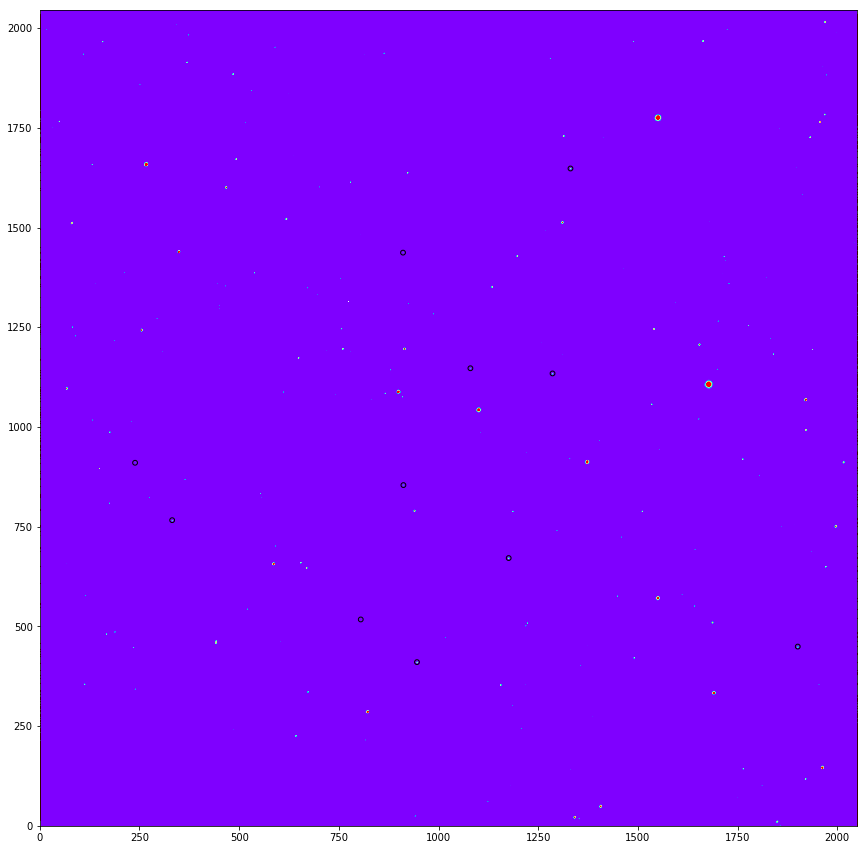

In [6]:
image_data=fits.getdata('wolfout21346_2.0003.fits')

plt.figure(figsize=(30,15))
plt.imshow(image_data,cmap='rainbow',norm=LogNorm(vmin=900,vmax=10000,clip=False))

ca.plot(ca(positions,6))
plt.gca().invert_yaxis()

In [7]:
Annulus_aperatures = can(positions, r_in=8.,r_out=12.)
Annulus_aperatures

<CircularAnnulus([[ 911, 1437],
                  [ 912,  854],
                  [ 805,  517],
                  [1286, 1134],
                  [1331, 1648],
                  [1901,  449],
                  [1176,  671],
                  [ 946,  410],
                  [ 239,  910],
                  [ 332,  766],
                  [1080, 1147]], r_in=8.0, r_out=12.0)>

C:\Users\Ben\Anaconda3\lib\site-packages\matplotlib\colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


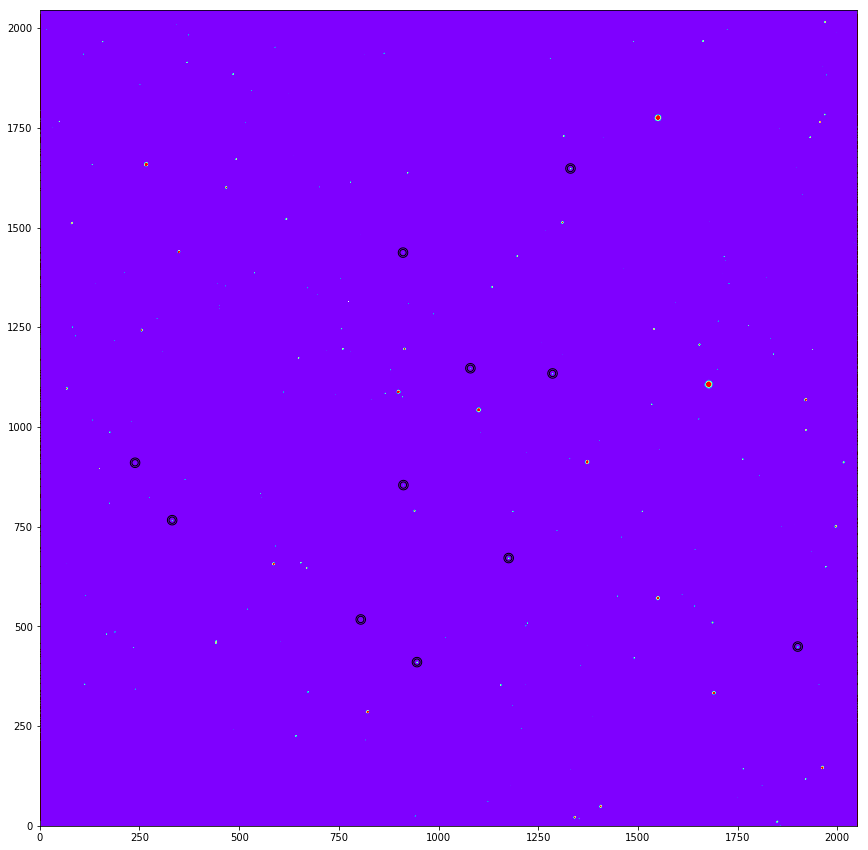

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(image_data,cmap='rainbow',norm=LogNorm(vmin=900,vmax=10000,clip=False))

can.plot(can(positions,8,12),)
plt.gca().invert_yaxis()

In [9]:
aperature_values=aperture_photometry(image_data,Annulus_aperatures,method='center')
mean_background=aperature_values['aperture_sum']/Annulus_aperatures.area()

aperture_value=aperture_photometry(image_data,apertures,method='exact')
sum_background=mean_background*apertures.area()
app_no_bkgrnd=aperture_value['aperture_sum']-(sum_background)

In [10]:
apertures = ca(positions, r=6.)
Annulus_aperatures = can(positions, r_in=8.,r_out=12.)
apers=[apertures,Annulus_aperatures]
phot_table = aperture_photometry(image_data,apers)
phot_table['residual_aperature_sum'] = app_no_bkgrnd

In [11]:
print(phot_table)

 id xcenter ycenter   aperture_sum_0     aperture_sum_1   residual_aperature_sum
      pix     pix                                                               
--- ------- ------- ------------------ ------------------ ----------------------
  1   911.0  1437.0  51170.67930939771  56870.16926924596      26308.70434161833
  2   912.0   854.0  44612.94897391452  56768.46191259734     19824.535099943037
  3   805.0   517.0 35784.919997020836  56283.11936917166     11189.618403661341
  4  1286.0  1134.0  71452.42316135802  58924.02858190663      45669.80983207932
  5  1331.0  1648.0  77557.42918449666 58059.644331963194     52143.611101159244
  6  1901.0   449.0  59625.98500469727  56416.77432779526      34959.11709222486
  7  1176.0   671.0   94784.4845811204 58381.871475278924      69222.46015848135
  8   946.0   410.0  84045.75644639226  57317.89481514186      58954.54924823373
  9   239.0   910.0 44840.279344495604  57400.32541745627     19768.112662274165
 10   332.0   766.0 64451.57

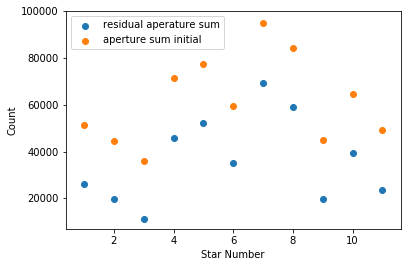

In [12]:
fig, ax = plt.subplots()
ax.scatter(phot_table["id"], phot_table["residual_aperature_sum"],label='residual aperature sum')
ax.scatter(phot_table["id"], phot_table["aperture_sum_0"], label='aperture sum initial')
plt.ylabel('Count')
plt.xlabel('Star Number')
plt.legend()
plt.show()

In [13]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [3]:
sigma_psf=2

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image_data)

iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))


In [2]:
result_tab = photometry(image=image_data)
residual_image = photometry.get_residual_image()

In [4]:
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                bkg_estimator=mmm_bkg,
                                psf_model=psf_model,
                                fitter=LevMarLSQFitter(),
                                fitshape=(11,11))
pos = Table(names=['x_0', 'y_0'], data=[phot_table['xcenter'],
                                        phot_table['ycenter']])

result_tab = photometry(image=image_data, init_guesses=pos)
residual_image = photometry.get_residual_image()
result_tab

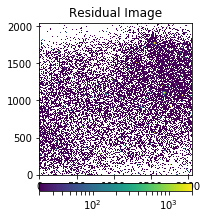

In [18]:
plt.subplots()
plt.imshow(image_data, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))

plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower', norm=LogNorm(20,2000))
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

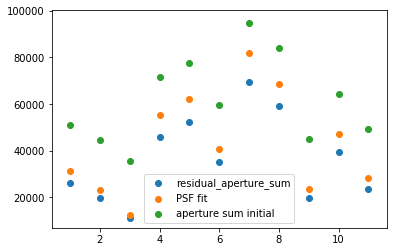

In [23]:
fig, ax = plt.subplots()

ax.scatter(phot_table["id"], phot_table["residual_aperature_sum"],label='residual_aperture_sum')
ax.scatter(result_tab["id"], result_tab["flux_fit"],label='PSF fit')

ax.scatter(phot_table["id"], phot_table["aperture_sum_0"],label = 'aperture sum initial')

plt.legend()
plt.show()